In [1]:
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd
import cmocean

from utils import Extent

In [2]:
# Read a GRIB2 files
files = Path("../data/20210626/").glob("*.grib2")
files = sorted(files)
file = files[350]

In [3]:
ds = xr.open_dataset(file, engine="cfgrib", decode_timedelta=False)
ds = ds.where(ds["unknown"] != -3)  # No Data
ds = ds.where(ds["unknown"] >= 1)  # No Data

ds


Ignoring index file '../data/20210626/PrecipRate_00.00_20210626-114200.grib2.5b7b6.idx' incompatible with GRIB file


<xarray.Dataset> Size: 98MB
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 8B 2021-06-26T11:42:00
    step            float64 8B 0.0
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      datetime64[ns] 8B 2021-06-26T11:42:00
Data variables:
    unknown         (latitude, longitude) float32 98MB nan nan nan ... nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-11T17:36 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
coarse = ds.coarsen(latitude=10, longitude=10).mean()
coarse


<xarray.Dataset> Size: 988kB
Dimensions:         (latitude: 350, longitude: 700)
Coordinates:
    time            datetime64[ns] 8B 2021-06-26T11:42:00
    step            float64 8B 0.0
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 3kB 54.95 54.85 54.75 ... 20.15 20.05
  * longitude       (longitude) float64 6kB 230.0 230.1 230.2 ... 299.8 299.9
    valid_time      datetime64[ns] 8B 2021-06-26T11:42:00
Data variables:
    unknown         (latitude, longitude) float32 980kB nan nan nan ... nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-11T17:36 GRIB to CDM+CF via cfgrib-0.9.1...

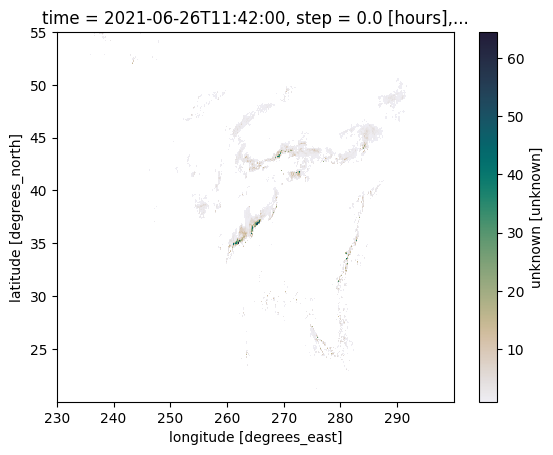

In [5]:
coarse["unknown"].plot(cmap=cmocean.cm.rain)

In [6]:
# Set boundaries
extent = Extent((20, 55), (-130, -60))

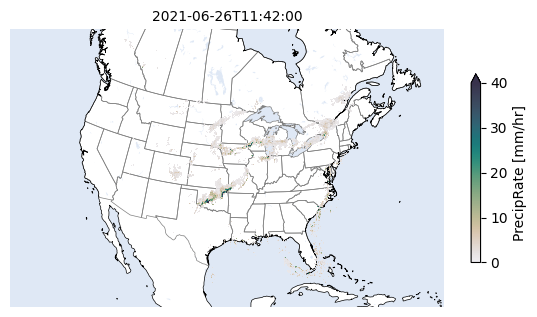

In [7]:
proj = ccrs.Orthographic(central_longitude=-90, central_latitude=40)
plate = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# CONUS extent
ax.set_extent(extent.as_mpl(), crs=plate)
ax.add_feature(cf.LAKES, alpha=0.3, zorder=1)
ax.add_feature(cf.OCEAN, alpha=0.3, zorder=1)
ax.add_feature(cf.STATES, zorder=1, lw=0.5, ec="gray")
ax.add_feature(cf.COASTLINE, zorder=1, lw=0.5)

coarse["unknown"].plot(
    cmap=cmocean.cm.rain,
    vmin=0,
    vmax=40,
    ax=ax,
    zorder=4,
    transform=plate,
    alpha=0.9,
    cbar_kwargs=dict(label="PrecipRate [mm/hr]", shrink=0.35),
)

timestr = np.datetime_as_string(coarse.time.values.copy(), unit="s")
ax.set_title(timestr, fontsize=10)

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

plt.show()
plt.close(fig)
